In [117]:
import os
import pickle
import h5py
import numpy as np
import torch
from torchvision import transforms as T
from torchvision import transforms
import cv2

import os
import h5py
import json
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as F
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt



DINO_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def crop_top_middle(image):
    top = 30
    left = 36
    height = 140
    width = 200
    return F.crop(image, top, left, height, width)



crop_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Lambda(lambda img: crop_top_middle(img)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
DINO_crop = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.1)),
    transforms.Lambda(lambda img: crop_top_middle(img)),
    transforms.Resize((224, 224)),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def resize_images_to_224(images):
    """Resize a batch of images to 224x224."""
    resized = []
    for i in range(len(images)):
        img = images[i]
        if i == 0:
            img_tensor = new_transform(img.astype(np.uint8))
        else:
            img_tensor = crop_transform(img.astype(np.uint8))
        resized.append(img_tensor.numpy().transpose(1, 2, 0))  # back to HWC
    return np.stack(resized)


In [118]:
dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
from sklearn.decomposition import PCA

def get_dino_features(dinov2, images):
    patch_h = 16
    patch_w = 16
    feat_dim = 384 # vits14
    N = 1
    """
    Extract DINOv2 features from a batch of images.
    
    Args:
        dinov2: The DINOv2 model.
        images: A batch of images as a tensor.
        
    Returns:
        A tensor of extracted features.
    """
    with torch.no_grad():
        features_dict = dinov2.forward_features(images)
        features = features_dict['x_norm_patchtokens']

    features = features.reshape(patch_h * patch_w, feat_dim)

    pca = PCA(n_components=3)
    pca.fit(features)
    pca_features = pca.transform(features)

    
    pca_features_bg = pca_features[:, 0] < -np.inf
    pca_features_fg = ~pca_features_bg

    # PCA for only foreground patches
    pca.fit(features[pca_features_fg]) # NOTE: I forgot to add it in my original answer
    pca_features_rem = pca.transform(features[pca_features_fg])
    for i in range(3):
        pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())

    pca_features_rgb = pca_features.copy()
    pca_features_rgb[pca_features_bg] = 0
    pca_features_rgb[pca_features_fg] = pca_features_rem

    pca_features_rgb = pca_features_rgb.reshape(N, patch_h, patch_w, 3)

    return pca_features_rgb

Using cache found in /home/kensuke/.cache/torch/hub/facebookresearch_dinov2_main


Loading expert data:   0% 0/681 [00:00<?, ?it/s]

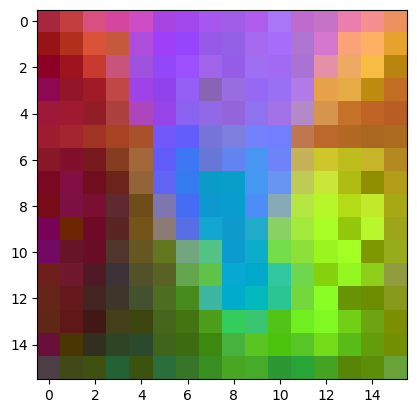

tensor(2.2043) tensor(-1.9980) torch.Size([3, 224, 224]) torch.float32


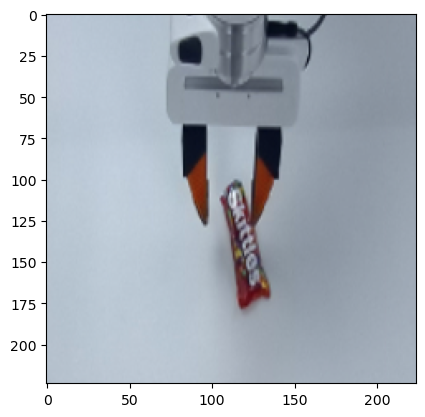

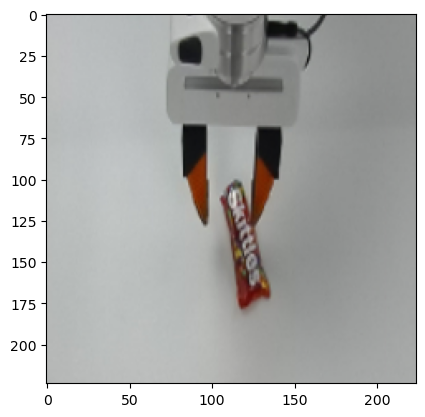

Loading expert data:   0% 1/681 [00:00<03:24,  3.33it/s]

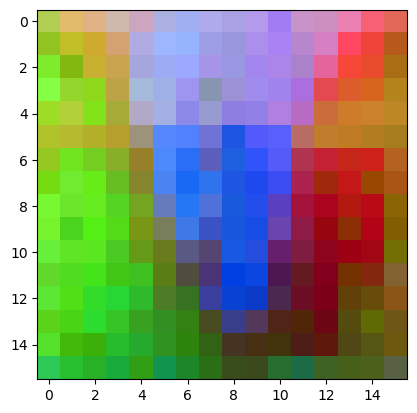

tensor(2.3088) tensor(-1.9467) torch.Size([3, 224, 224]) torch.float32


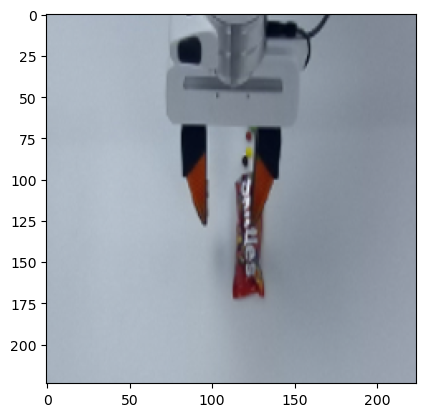

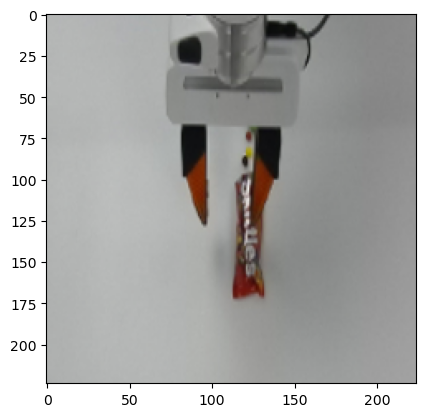

Loading expert data:   0% 2/681 [00:00<03:28,  3.25it/s]

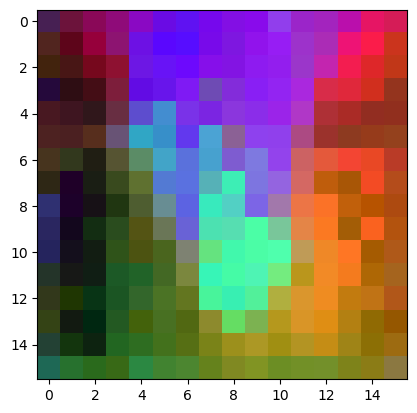

tensor(1.7163) tensor(-1.9124) torch.Size([3, 224, 224]) torch.float32


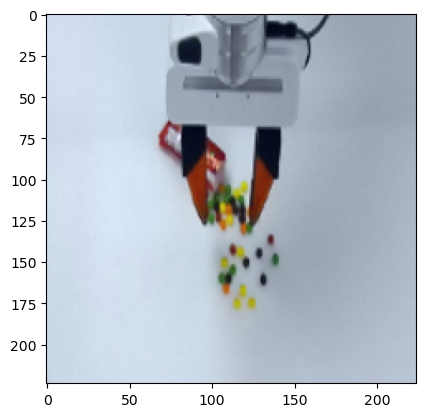

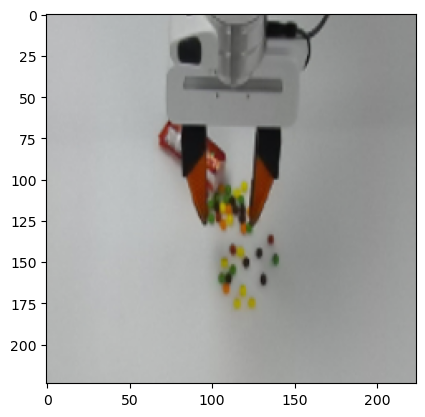

In [121]:
demo_path = '/data/ken/latent-labeled'


# Path to HDF5 files
hdf5_files = [os.path.join(demo_path, f) for f in os.listdir(demo_path) if f.endswith('.hdf5')]

pixel_keys = ["rs", "zed_right"]

all_acs = []
transitions = 0

blur_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])



for i, hdf5_file in tqdm(enumerate(hdf5_files), desc="Loading expert data", total=len(hdf5_files), ncols=0, leave=False):
    with h5py.File(hdf5_file, "r+") as f:
        data_group = f["data"]
        if "camera_0" not in data_group or "camera_1" not in data_group:
            print(f"Skipping {hdf5_file} due to missing camera data.")
            continue
        cam_zed = data_group["camera_1"][:]
        
       
        for t in range(cam_zed.shape[0]):
            # Zed front image
            zed_img = cam_zed[t]
            #print(zed_img.shape, zed_img.min(), zed_img.max(), zed_img.dtype)
            #zed_img = np.uint8(blur_transform(zed_img).permute(1, 2, 0).numpy()*255)
            #print(zed_img.shape, zed_img.min(), zed_img.max(), zed_img.dtype)

            '''clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            lab = cv2.cvtColor(zed_img, cv2.COLOR_RGB2LAB)
            lab[..., 0] = clahe.apply(lab[..., 0])
            zed_img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)'''

            img_PIL = Image.fromarray(np.uint8(zed_img)).convert('RGB')
            img_tensor = DINO_crop(img_PIL)
            dino_tensor = get_dino_features(dinov2, img_tensor.unsqueeze(0))
            plt.imshow(dino_tensor[0][..., ::-1])
            plt.show()
            print(img_tensor.max(), img_tensor.min(), img_tensor.shape, img_tensor.dtype)
            img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())
            plt.imshow(img_tensor.permute(1, 2, 0).numpy())
            plt.show()
            plt.imshow(crop_transform(zed_img).permute(1, 2, 0).numpy())
            plt.show()
            
            break
    if i > 1: 
        break